                     method  samples     class_distribution  accuracy  \
0                       QBS      111  {1: 40, 2: 37, 0: 34}  0.833333   
1                  NearMiss      117  {0: 39, 1: 39, 2: 39}  0.800000   
2               CondensedNN       48    {2: 39, 1: 8, 0: 1}  0.366667   
3                TomekLinks      118  {0: 40, 1: 39, 2: 39}  0.800000   
4                  EditedNN      115  {0: 40, 2: 39, 1: 36}  0.766667   
5         OneSidedSelection       61   {2: 39, 1: 21, 0: 1}  0.400000   
6  NeighborhoodCleaningRule      117  {0: 40, 2: 39, 1: 38}  0.800000   

   precision    recall  f1_score  
0   0.873016  0.814815  0.801492  
1   0.855556  0.777778  0.751748  
2   0.122222  0.333333  0.178862  
3   0.855556  0.777778  0.751748  
4   0.840278  0.740741  0.695847  
5   0.223285  0.370370  0.277778  
6   0.855556  0.777778  0.751748  


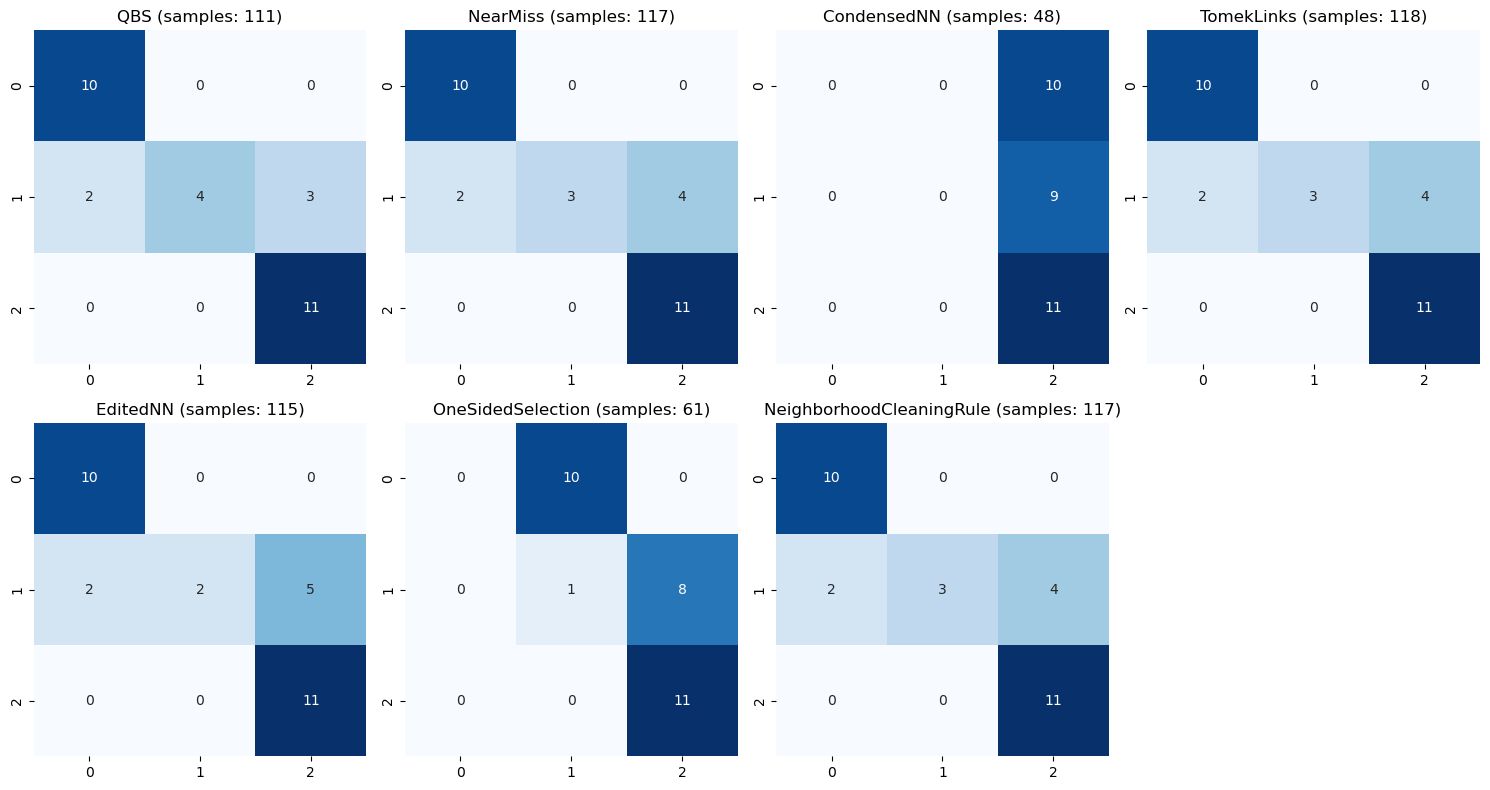

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import (NearMiss, CondensedNearestNeighbour,
                                     TomekLinks, EditedNearestNeighbours,
                                     OneSidedSelection, NeighbourhoodCleaningRule)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import warnings
warnings.filterwarnings('ignore')

# QBS undersampler
class QBS:
    def __init__(self, n=None):
        self.n = n
    
    def _calculate_quantiles(self, X, q):
        quantiles = []
        for i in range(X.shape[1]):
            quantiles.append(np.percentile(X[:, i], np.linspace(0, 100, q + 1)))
        return quantiles

    def _find_closest_sample(self, combination, X, quantiles):
        distances = cdist([combination], X, metric='euclidean')
        return np.argmin(distances)
    
    def fit_resample(self, X, y):
        n = self.n if self.n is not None else \
            min({l: y.tolist().count(l) for l in set(y)}.values()) 
        d = X.shape[1]
        q = int(d * np.log(n) / np.log(d))
        quantiles = self._calculate_quantiles(X, q)

        combinations = np.array(np.meshgrid(*quantiles)).T.reshape(-1, d)
        subset_indices = []

        for combination in combinations:
            idx = self._find_closest_sample(combination, X, quantiles)
            if idx not in subset_indices:
                subset_indices.append(idx)

        X_sub = X[subset_indices]
        y_sub = y[subset_indices]

        return X_sub, y_sub

# Load example dataset
data = datasets.load_iris()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

undersampling_methods = {
    'QBS': QBS(),
    'NearMiss': NearMiss(version=1),
    'CondensedNN': CondensedNearestNeighbour(random_state=RANDOM_STATE),
    'TomekLinks': TomekLinks(),
    'EditedNN': EditedNearestNeighbours(),
    'OneSidedSelection': OneSidedSelection(random_state=RANDOM_STATE),
    'NeighborhoodCleaningRule': NeighbourhoodCleaningRule()
}

results = []

for name, method in undersampling_methods.items():
    try:
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', MLPClassifier((4, 3), random_state=RANDOM_STATE))
        ])

        # Train and evaluate the model
        pipeline.fit(X_resampled, y_resampled)
        y_pred = pipeline.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        results.append({
            'method': name,
            'samples': len(X_resampled),
            'class_distribution': dict(pd.Series(y_resampled).value_counts()),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        })
    except Exception as e:
        print(f'{name}: {e}')

# Display results
results_df = pd.DataFrame(results)
print(results_df[['method', 'samples', 'class_distribution', 'accuracy', 'precision', 'recall', 'f1_score']])

# Plot confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, result in enumerate(results):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{result['method']} (samples: {result['samples']})")

# Remove extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()